In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from preprocessing import merge_dfs    

In [4]:
df = merge_dfs()

Unike verdier i "Felt": ['1' '2' 'Totalt i retning Danmarksplass' 'Totalt i retning Florida'
 'Totalt']
       Trafikkmengde
count   65250.000000
mean       50.380552
std        69.841572
min         0.000000
25%         5.000000
50%        25.000000
75%        64.000000
max       608.000000
Andel av værdata som inneholder "Relativ Luftfuktighet: 0.11075391168620219
       Globalstraling    Solskinstid  Lufttemperatur    Vindretning  \
count   707823.000000  707822.000000   707822.000000  707824.000000   
mean       157.308492      70.214651       49.650598     247.069506   
std        828.637784     827.357277      641.437364     659.156188   
min        -97.200000       0.000000      -11.400000       2.000000   
25%         -0.400000       0.000000        4.100000     146.000000   
50%          5.600000       0.000000        8.100000     164.000000   
75%        101.200000       0.000000       12.600000     298.000000   
max       9999.990000    9999.990000     9999.990000    9999.99

In [5]:
# Lagre 2023 data til senere
data_2023 = df[df['Aarstall'] == 2023].drop(columns=['Trafikkmengde'])

# Droppe kolonner der trafikkmengde er nan
data = df[df['Aarstall'] != 2023]
data = data.dropna(subset=['Trafikkmengde'])

# Dele i features og target, og splitte datasettet i trenings-og testdata
X = data.drop(columns=['Trafikkmengde'])
y = data['Trafikkmengde']

# Splitter dataen
X_train, X_test, y_train, y_test = train_test_split(X, y ,shuffle=False, test_size=0.3)

In [6]:

# Korrelasjonsmatrise
train_df = pd.concat([X_train, y_train], axis=1)
train_df

,Solskinstid,Lufttemperatur,Vindstyrke,Lufttrykk,Vindkast,Globalstraling,Vindretning,Ukedag,Maaned,Aarstall,Klokkeslett,Rod_dag,Trafikkmengde
Tidspunkt,,,,,,,,,,,,,
2015-07-16 16:00:00,48.7,13.733333,4.333333,1014.400000,7.20,432.833333,317.500000,3,7,2015,16,0,101.0
2015-07-16 17:00:00,60.0,13.866667,3.933333,1014.066667,6.55,378.400000,318.166667,3,7,2015,17,0,79.0
2015-07-16 18:00:00,60.0,13.216667,4.233333,1013.966667,7.15,212.583333,319.833333,3,7,2015,18,0,56.0
2015-07-16 19:00:00,60.0,12.683333,2.950000,1014.100000,5.45,79.750000,323.500000,3,7,2015,19,0,45.0
2015-07-16 20:00:00,36.0,12.066667,2.483333,1014.200000,4.25,10.633333,333.500000,3,7,2015,20,0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-07 04:00:00,0.0,11.416667,1.583333,988.866667,2.25,NaN,146.166667,2,10,2020,4,0,1.0
2020-10-07 05:00:00,0.0,11.083333,0.900000,989.266667,1.60,NaN,132.500000,2,10,2020,5,0,7.0
2020-10-07 06:00:00,0.0,10.833333,0.533333,989.700000,1.10,12.883333,151.166667,2,10,2020,6,0,58.0


In [7]:

print(f'Korrelasjonsmatrise:\n{train_df.corr()}\n')
# Create a heatmap for the confusion matrix


Korrelasjonsmatrise:
                Solskinstid  Lufttemperatur  Vindstyrke  Lufttrykk  Vindkast  \
Solskinstid        1.000000        0.315661   -0.016946   0.190664 -0.020612   
Lufttemperatur     0.315661        1.000000    0.050136   0.132277  0.059380   
Vindstyrke        -0.016946        0.050136    1.000000  -0.201025  0.978796   
Lufttrykk          0.190664        0.132277   -0.201025   1.000000 -0.238094   
Vindkast          -0.020612        0.059380    0.978796  -0.238094  1.000000   
Globalstraling     0.695527        0.359671    0.035749   0.213422  0.027846   
Vindretning        0.240402        0.133406   -0.112087   0.079840 -0.080431   
Ukedag            -0.019444        0.001069   -0.008075  -0.022918 -0.006663   
Maaned            -0.048512        0.263391   -0.073235   0.006422 -0.058993   
Aarstall           0.046951        0.002198    0.025963  -0.044237  0.025911   
Klokkeslett        0.019443        0.065897    0.050939   0.007577  0.050920   
Rod_dag            

In [32]:
# Create a heatmap
def correlations(df):
    correlations = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

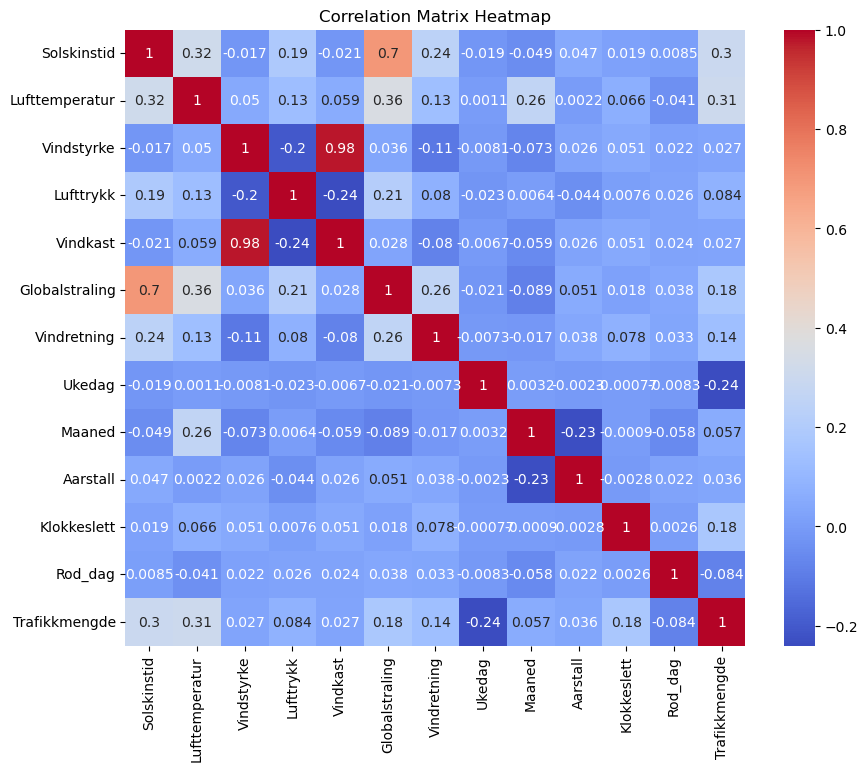

In [33]:
correlations(train_df)

In [43]:
train_df

,Solskinstid,Lufttemperatur,Vindstyrke,Lufttrykk,Vindkast,Globalstraling,Vindretning,Ukedag,Maaned,Aarstall,Klokkeslett,Rod_dag,Trafikkmengde
Tidspunkt,,,,,,,,,,,,,
2015-07-16 16:00:00,48.7,13.733333,4.333333,1014.400000,7.20,432.833333,317.500000,3,7,2015,16,0,101.0
2015-07-16 17:00:00,60.0,13.866667,3.933333,1014.066667,6.55,378.400000,318.166667,3,7,2015,17,0,79.0
2015-07-16 18:00:00,60.0,13.216667,4.233333,1013.966667,7.15,212.583333,319.833333,3,7,2015,18,0,56.0
2015-07-16 19:00:00,60.0,12.683333,2.950000,1014.100000,5.45,79.750000,323.500000,3,7,2015,19,0,45.0
2015-07-16 20:00:00,36.0,12.066667,2.483333,1014.200000,4.25,10.633333,333.500000,3,7,2015,20,0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-07 04:00:00,0.0,11.416667,1.583333,988.866667,2.25,NaN,146.166667,2,10,2020,4,0,1.0
2020-10-07 05:00:00,0.0,11.083333,0.900000,989.266667,1.60,NaN,132.500000,2,10,2020,5,0,7.0
2020-10-07 06:00:00,0.0,10.833333,0.533333,989.700000,1.10,12.883333,151.166667,2,10,2020,6,0,58.0


In [50]:
def boxplots(df):
    plt.boxplot(df)
    # Add labels and a title
    plt.title('Boxplot of a DataFrame Feature')
    plt.xlabel('Data')
    plt.ylabel('Values')
    plt.show()

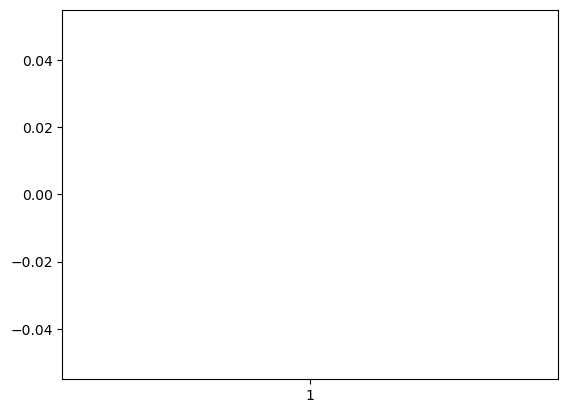

In [52]:
boxplots(train_df["Lufttrykk"])

In [22]:
train_df

,Solskinstid,Lufttemperatur,Vindstyrke,Lufttrykk,Vindkast,Globalstraling,Vindretning,Ukedag,Maaned,Aarstall,Klokkeslett,Rod_dag,Trafikkmengde
Tidspunkt,,,,,,,,,,,,,
2015-07-16 16:00:00,48.7,13.733333,4.333333,1014.400000,7.20,432.833333,317.500000,3,7,2015,16,0,101.0
2015-07-16 17:00:00,60.0,13.866667,3.933333,1014.066667,6.55,378.400000,318.166667,3,7,2015,17,0,79.0
2015-07-16 18:00:00,60.0,13.216667,4.233333,1013.966667,7.15,212.583333,319.833333,3,7,2015,18,0,56.0
2015-07-16 19:00:00,60.0,12.683333,2.950000,1014.100000,5.45,79.750000,323.500000,3,7,2015,19,0,45.0
2015-07-16 20:00:00,36.0,12.066667,2.483333,1014.200000,4.25,10.633333,333.500000,3,7,2015,20,0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-07 04:00:00,0.0,11.416667,1.583333,988.866667,2.25,NaN,146.166667,2,10,2020,4,0,1.0
2020-10-07 05:00:00,0.0,11.083333,0.900000,989.266667,1.60,NaN,132.500000,2,10,2020,5,0,7.0
2020-10-07 06:00:00,0.0,10.833333,0.533333,989.700000,1.10,12.883333,151.166667,2,10,2020,6,0,58.0
